# Notebook to Retrieve Data from the BCB API
---
This notebook offers a user-friendly interface for accessing data from the Banco Central do Brasil (BCB) API, emphasizing data tracking and reproducibility.

### Logging and Tracking
- **Detailed Command Logging**:  
  - **Info-Level Logging in the Notebook**: During the notebook session, commands are logged at the info level, meaning important events and steps are recorded to help users understand what actions have been taken.  
  - **Debug-Level Logging to a File**: A separate log file captures more granular, debug-level details. This enables deeper troubleshooting if issues arise, while keeping the notebook interface focused on higher-level information.  
  - **Unique Session Logs**: For each notebook session, a new log file is generated and identified with a unique ID. This ensures that logs from one session don’t overwrite another, making it easier to track actions and resolve issues in the future.

- **File Traceability via Hashing**:  
  - Each file created by the notebook is assigned a unique identifier.  
  - The file’s hash is computed and stored in the log file. This provides a reliable way to verify file integrity and maintain a clear link between the file and its corresponding session, allowing users to trace the origins of data and detect any changes over time.


## Notebook Setup and Dependencies Loading
---

Run the cell below in order to load dependencies, metadata, and start the logging session.

In [2]:
# Importing external libraries and functions
import os
import sys
import hashlib
import pandas as pd
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown
from datetime import datetime

# Add the 'src' folder to the Python path so project-specific modules can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

# Import project-specific functions
from logger import start_logger
from bcb import fetch_bcb_series, load_bcb_series_metadata

# Enable automatic reloading of modules when their source code changes
%reload_ext autoreload
%autoreload 2

# Define Session ID
session_type = "BCB"
session_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

# Setup Logging
log_file_name = f"../logs/{session_type}_{session_ID}.log"
logger_name = "root"
logger = start_logger(logger_name, log_file_name)

# Load BCB series metadata
df_bcb_series_metadata = load_bcb_series_metadata()

2025-03-29 11:26:32,549 - INFO - Logger started. File path: ../logs/BCB_20250329_112632.log
2025-03-29 11:26:32,550 - INFO - Loaded BCB Metadata from file: ../data/metadata/bcb_series.json


## Select Date Range and Series for BCB API Query
---

Specify the start and end dates to define the query period for the BCB API.  
- The **start date** is required.  
- The **end date** is optional and can be left blank to fetch data up to the latest available record.  
- Use the format: **DD/MM/YYYY**.

To include additional series in the list, update the BCB metadata JSON file.  

Refer to the log file for the metadata file name and location. The file can be edited manually using any text editor.

After making changes, **re-run the cell above** to reload the updated metadata into the notebook.

In [3]:
# Date pickers for selecting the data range
start_date_widget = widgets.DatePicker(
    description='Start Date',
    value=datetime.strptime("01/01/2025", "%d/%m/%Y"),  # Default value
    disabled=False,
    layout=widgets.Layout(width='250px')  # Adjust width for consistency
)

end_date_widget = widgets.DatePicker(
    description='End Date',
    value=None,  # Leave as None to fetch up to the most recent available data
    disabled=False,
    layout=widgets.Layout(width='250px')
)

# Dropdown for selecting a series by name (from metadata index)
series_dropdown = widgets.Dropdown(
    options=df_bcb_series_metadata.index.tolist(),  # Populate with all series names
    value="Selic",  # Default selected series
    description='Series',
    layout=widgets.Layout(width='400px')  # Wider to accommodate long names
)

# Output widget to display the selected series' description
description_out = widgets.Output()

# Callback function to update the description when a new series is selected
def update_description(change):
    with description_out:
        description_out.clear_output()
        selected = change['new']
        desc = df_bcb_series_metadata.loc[selected, "Descrição"]
        display(Markdown(f"**Series Description:** {desc}"))  # Show description in Markdown format

# Attach the callback to the dropdown
series_dropdown.observe(update_description, names="value")

# Display the date pickers vertically
display(widgets.VBox([start_date_widget, end_date_widget]))

# Display dropdown and description area
display(series_dropdown, description_out)

# Trigger the description display for the initially selected series
update_description({'new': series_dropdown.value})

Dropdown(description='Series', layout=Layout(width='400px'), options=('Selic', 'Spread médio PF', 'Concessões …

Output()

## Make API Request and Save Data

2025-03-29 11:26:36,686 - INFO - Requesting BCB series 11 from 01/01/2025 to 29/03/2025
2025-03-29 11:26:37,930 - INFO - Successfully fetched 60 rows for series 11
2025-03-29 11:26:37,931 - INFO - File saved: ../data/raw/BCB-Serie-11_20250329_112632_112637.csv


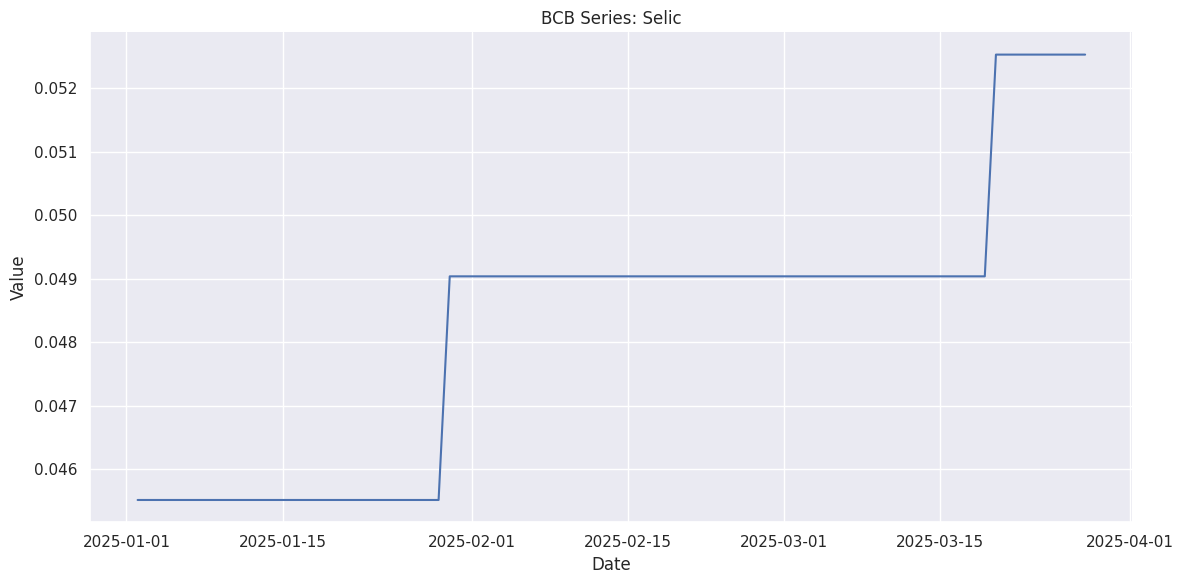

In [4]:
# Format helper to convert widget date to DD/MM/YYYY string
def format_date(date_obj):
    return date_obj.strftime("%d/%m/%Y") if date_obj else None

# Get start and end dates from widgets
start_date = format_date(start_date_widget.value)
end_date = format_date(end_date_widget.value)

# Validate that start date is set
assert start_date is not None, "Start date is required. Please select a start date."

# Get selected series code from metadata
selected_series_name = series_dropdown.value
series_code = df_bcb_series_metadata.loc[selected_series_name, "code"]

# Request data from BCB API
df = fetch_bcb_series(series_code, start_date, end_date)

# Generate file ID using current time (HHMMSS)
file_ID = datetime.now().strftime("%H%M%S")
log_file_name = f"../data/raw/{session_type}-Serie-{series_code}_{session_ID}_{file_ID}.csv"

# Save DataFrame to CSV without the index
df.to_csv(log_file_name, index=False)
logger.info(f"File saved: {log_file_name}")

# Compute SHA-256 hash of the saved file
with open(log_file_name, "rb") as f:
    file_bytes = f.read()
    file_hash = hashlib.sha256(file_bytes).hexdigest()

# Log the hash for traceability
logger.debug(f"SHA-256 hash of saved file: {file_hash}")

# Plot data
## Use notebook-friendly Seaborn style
sns.set_theme()
sns.set_context("notebook")

## Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="data", y="valor")

## Add labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title(f"BCB Series: {selected_series_name}")

## Clean up borders
sns.despine()

## Display
plt.tight_layout()
plt.show()
